## 0. Required dependencies ##
You'll need recent versions of jupyter (but if you're reading this, you are probably OK), opencv-python (and probably opencv-contrib-python), tqdm, scikit-learn, numpy, pandas and matplotlib. I've included a requirements.txt file for your convenience, but I basically use the most recent versions of everything, and the code works.

I advise you to use a form of virtual environments to manage your python projects (e.g. pipenv, venv, conda etc.).

To get free GPU time, you can try Google Colab. It is a tool for running notebooks, and provides you with a VM and a GPU for free! Most of the recent packages used in ML are automatically installed, so that is also nice.

In [28]:
# standard packages used to handle files
import sys
import os 
import glob
import time

# commonly used library for data manipulation
import pandas as pd

# numerical
import numpy as np

# handle images - opencv
import cv2

# machine learning library
import sklearn
import sklearn.preprocessing

# used to serialize python objects to disk and load them back to memory
import pickle

# plotting
import matplotlib.pyplot as plt

# helper functions
import helpers

# specific helper functions for feature extraction
import features

# tell matplotlib that we plot in a notebook
%matplotlib notebook

In [29]:
# filepath constants, set these according to your workflow:

# where are your datasets:
dataset_path = 'datasets'
# where do you want to save your features and other outputs:
output_path = 'predictions'

In [30]:
# you don't have to change the paths here:

dataset_path_train = os.path.join(dataset_path, 'train')
dataset_path_test = os.path.join(dataset_path, 'test')

features_path = os.path.join(output_path, 'features')
features_path_train = os.path.join(features_path, 'train')
features_path_test = os.path.join(features_path, 'test')

prediction_path = os.path.join(output_path, 'predictions')

# filepatterns to write out features
filepattern_descriptor_train = os.path.join(features_path_train, 'train_features_{}.pkl')
filepattern_descriptor_test = os.path.join(features_path_test, 'test_features_{}.pkl')

# create paths in case they don't exist:
helpers.createPath(features_path)
helpers.createPath(features_path_train)
helpers.createPath(features_path_test)
helpers.createPath(prediction_path)

## 1. Loading the data and the labels
First, let's get the training labels. The train data is ordered in a way such that all images in a class are stored in a separate folder, thus we can simply get a string represenation of the labels by using the folder names.

In [31]:
folder_paths = glob.glob(os.path.join(dataset_path_train,'*'))
label_strings = np.sort(np.array([os.path.basename(path) for path in folder_paths]))
num_classes = label_strings.shape[0]

print("Amount of classes: ", num_classes)
print("\nLabels: \n", label_strings)

Amount of classes:  12

Labels: 
 ['chicken' 'elephant' 'fox' 'german_shepherd' 'golden_retriever' 'horse'
 'jaguar' 'lion' 'owl' 'parrot' 'swan' 'tiger']


Since loading all images of the train set into memory at once is hardly feasible, we simply collect all their filepaths and load them on demand. Therefore, we build a dictionary of the filepaths to all our train images, sorted by label. We do the same for our test images.

In [32]:
train_paths = dict((label_string, helpers.getImgPaths(os.path.join(dataset_path_train, label_string))) 
                   for label_string in label_strings)

test_paths = helpers.getImgPaths(dataset_path_test)

Let's take a look at a few examples of each class. We start by loading and displaying the first image of the 'tiger' class. Images loaded using OpenCV can be displayed using pyplot. One has to mind conventions: while using OpenCV, image channels are stored in the order blue-green-red, but pyplot assumes images to be stored in the more common RGB format. Luckily OpenCV's <code>cvtColor</code> method enables straight-forward conversion between the formats:

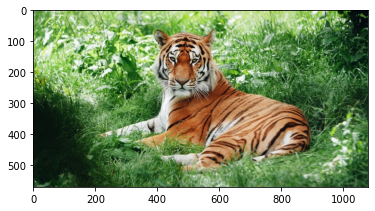

In [33]:
# load first image of class bobcat using opencv:
image = cv2.imread(train_paths['tiger'][0])

# images can be plotted using matplotlib, but need to be converted from BGR to RGB
%matplotlib inline
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

Alright, let's see if we can learn more about how the different color channels are aligned in a numpy array which holds the image data. We'll plot each color channel individually:

Image shape: (570, 1080, 3)


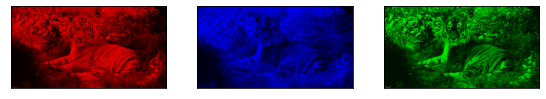

In [34]:
# blue, green and red channels are aligned along the third dimension of the returned numpy array
print('Image shape: {}'.format(image.shape))


# compute aspect ratio of image 
(height, width, nr_channels) = image.shape

aspect_ratio = width / float(height)

fig_height = 5

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(fig_height * aspect_ratio, fig_height))
[ax.get_xaxis().set_visible(False) for ax in axes]
[ax.get_yaxis().set_visible(False) for ax in axes]
ax0, ax1, ax2 = axes

# extract blue, green and red channels from image
blue_channel = image[:, :, 0]
green_channel = image[:, :, 1]
red_channel = image[:, :, 2]

ax0.imshow(np.dstack([red_channel, np.zeros_like(blue_channel), np.zeros_like(blue_channel)]))
ax1.imshow(np.dstack([np.zeros_like(green_channel), np.zeros_like(green_channel), green_channel]))
ax2.imshow(np.dstack([np.zeros_like(red_channel), blue_channel, np.zeros_like(red_channel)]))

plt.show()

## 2. Looking at the data
As we are warmed up now, we plot the first 3 images of each class to get a first impression on what our data looks like.

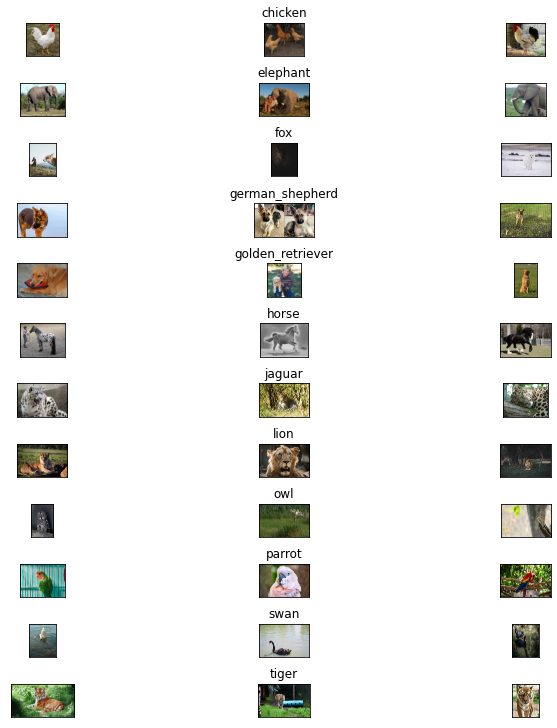

In [35]:
fig, axes = plt.subplots(nrows=num_classes, ncols=3, constrained_layout=True, figsize=(10, 10))

[ax.get_xaxis().set_visible(False) for ax_row in axes for ax in ax_row]
[ax.get_yaxis().set_visible(False) for ax_row in axes for ax in ax_row]

for idx, label_string in enumerate(label_strings):
    images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in train_paths[label_string][:3]]

    for colidx in range(3):
        axes[idx, colidx].imshow(images[colidx])
        if colidx == 1: # if this is the center column
            axes[idx, colidx].set_title(label_string)

plt.show()    

We can see that the images are quite diverse and vary in scale, viewpoint etc. This means that we will have to be careful to use the right feature descriptors in the feature extraction stage. We would prefer features which show a certain kind of invariance to this diversity. The dataset has been scraped from the web, which means that we can expect some degree of label noise as well.

## 2. The Bag-Of-Visual-Words model

The concept of a bag-of-words (BoW) model originates from the field of Natural Language Processing (NLP). In NLP problems, the input is text. However, for a machine learning model, we need numerical features as input. One way to translate text to features is to use part of its natural structure: the grouping of characters into words. To construct a BoW-model, you do the following (with possible fine-tunings for each step):

* Make a histogram of all the words in the text, throw out words that are not important (e.g., typos, words in another language, short words like 'the', 'an', 'of', ...) and possibly group similar words (e.g., conjugations of the same verb, synonyms ...).
* Keep the k most frequently occurring words (with k a hyperparameter).
* For each document, make a (k x 1) vector for which the i-th value corresponds to the number of times the i-th word occurs in that document.
* Additionally, or as an alternative, you can also make binary vectors (only recording whether or not a word occurs in a document, not how frequently).

This gives you long but sparse feature vectors that you can use in a machine learning model.

In a visual BoW, we do something similar for images. The problem is that there aren't any 'words' naturally available. Instead, we want to look for 'typical local structures' in the image (e.g. small significant areas or patches). Obviously, this shifts the problem to defining what 'typical patches' are. Luckily, there exist a range of feature extractors in image processing that detect those interesting patches. What this means exactly depends on the specific feature type, but these patches (or transformed representations of those) can be used to construct a dictionary for images. How this is done exactly is explained in more detail in the 'creating_vbow' notebook on this topic. It basically boils down to the following:

* We extract the chosen type of features for all the images in the training set (the maximal number is upper bounded by a hyperparameter).
* Accross this huge set of patches, we cluster similar patches together into a set number of classes (another hyperparameter, which sets the number of BoW features), and compute the 'average patch' for each cluster -- these are the visual 'words'.
* We then encode each image (from train set or test set) in a similar way to the BoW model: we assign each extracted patch to a cluster (word) and count how many times each cluster occurs in each image.

For the competition, the focus lies on correctly applying and implementing the standard machine learning flow. In order to get you started, we have implemented a simple version of this BoW procedure for you. As a first step, we advise you to simply use that and focus on everything else. If you want to aim for excellent scores, you can try improving this simple VBoW approach by tuning the extraction yourself. Note that this uses k-means clustering, a very commmon unsupervised technique for clustering. You can find a lot of information on this technique on the web.

In what follows, we only show you how to use the code provided by us. For the details of the code itself, we refer to the second notebook and the code in the 'features' file.

## 3. Using the provided image features

Download the feature files provided on the Kaggle competition site. These contain raw image features before the creation of clusters and the counting of the visual words. You can also re-extract them yourself using the code in the 'creating_vbow' notebook, or extract other kinds of features there.

In what follows, we simply load the extracted features from disk. They are stored as pickle files, which are just files serialized for python.

In this case, we'll use the freak features provided to you. But definitely read the creating_vbow notebook and take a look at the other features, it could inspire you to try new things.

In [140]:
descriptor_desired = 'daisy_shi_dist_thirteen_800_800pxcrop' #daisy>sift>vgg>freak>boost_desc>lucid>orb    with cookbook = 500

In [141]:
with open(filepattern_descriptor_train.format(descriptor_desired), 'rb') as pkl_file_train:
    train_features_from_pkl = pickle.load(pkl_file_train)
    
print('Number of encoded train images: {}'.format(len(train_features_from_pkl)))

Number of encoded train images: 4042


In [142]:
with open(filepattern_descriptor_test.format(descriptor_desired), 'rb') as pkl_file_test:
    test_features_from_pkl = pickle.load(pkl_file_test)
        
print('Number of encoded test images: {}'.format(len(test_features_from_pkl)))

In [142]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, log_loss,make_scorer
from sklearn.svm import SVC
from sklearn import decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

The next thing we need to do is to cluster the training features into the words that will construct our dictionary. You are NOT allowed to use features from the test images to do this. Even if you did use the test images, it would not improve your final performance, since you are overfitting your model on the test set, which is an error you have to avoid at all times. In addition, when using validation or cross-validation, the validation set should also not be used here. Think about your clustering and your train/test/validations splits, and how you will avoid information leakage here...

Note that the number of categories (words) is a hyperparameter that should be optimised, ideally with grid search, but you can also try it manually. For this starting example, we give it a try with <code>codebook_size=500</code>. 

The functions we use below are implemented in the 'helpers' library. Our kind thanks go out to the authors of [https://github.com/flytxtds/scene-recognition](https://github.com/flytxtds/scene-recognition), from where this code has been adapted. 

The code below creates the desired encoded BoW feature vector.

**Important note:** if you were to encounter an error, similar to 'ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index X has 0 dimension(s)', or: 'ValueError: Expected 2D array, got scalar array instead: array=nan.', this is because your feature descriptor has found no patches on a certain image. If this is in your training set, you can simply remove this image and recreate your features. You can find the image for the former error by printing

    train_features_from_pkl[X] 

(with X the index from your error message), or for the latter error with

    for i, img in enumerate(train_features_from_pkl):
        try:
            _ = len(img.data)
        except ValueError as e:
            print(img)

Let me know what image it was, and I'll update the dataset on Kaggle for the others. It is especially important to let me know if this error occurred in the test set, since otherwise you won't be able to submit a good submission. You can send an e-mail to andries.rosseau@vub.be.

In [143]:
# learn the codebook for the 'freak' features from the training data
#daisy 2500>2000>1200>800>500>250>100 for log reg optimal result lies between 3000 and 1200. 3000 gave us worse than 2000!!!
#sift takes way too long, might wanna use some online software for that saturn for example
codebook_size = 2500

clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=codebook_size)

training took 1044.2822377681732 seconds


In [144]:
# encode all train images 
train_data = []
train_labels = []

for image_features in train_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    train_data.append(bow_feature_vector)
    train_labels.append(image_features.label)

In [145]:
# encode all test images 
test_data = []
for image_features in test_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    test_data.append(bow_feature_vector)

Now that we have readily useable train and test data matrices, there is only one thing missing: our label vector still contains string representations of our labels, but in order to train a supervised classifier, we need the labels to be represented as integers of course. The <code>LabelEncoder</code> class of sklearn does exactly that.

In [146]:
# use a labelencoder to obtain numerical labels
label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(label_strings)
print(train_labels[:10])
train_labels = label_encoder.transform(train_labels)
print(train_labels[:10])

In [217]:
#https://chrisalbon.com/machine_learning/model_evaluation/plot_the_learning_curve/
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
X = train_data
Y = train_labels
X, X_DEV , Y , Y_DEV = train_test_split(train_data,train_labels,test_size = 0.3,random_state=42) #0.8 split gave us optimal results!
LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

def plot_cluster_graph(minimum, maximum   , step):
    amount_of_zeroes = (maximum-minimum) // step
    DEV_errors = np.zeros(amount_of_zeroes)
    X_errors = np.zeros(amount_of_zeroes)
    codebook_sizes = np.zeros(amount_of_zeroes)
    idx = 0
    for i in range(minimum, maximum , step):
        codebook_size = i
        print(str(codebook_size))
        
        
        clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=codebook_size)
        
        train_data = []
        train_labels = []
        for image_features in train_features_from_pkl:
            bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
            train_data.append(bow_feature_vector)
            train_labels.append(image_features.label)
            
            
        test_data = []
        for image_features in test_features_from_pkl:
            bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
            test_data.append(bow_feature_vector)
        
        label_encoder = sklearn.preprocessing.LabelEncoder()
        label_encoder.fit(label_strings)
        print(train_labels[:10])
        train_labels = label_encoder.transform(train_labels)
        print(train_labels[:10])
        
        X, X_DEV , Y , Y_DEV = train_test_split(train_data,train_labels,test_size = 0.3,random_state=42) #0.8 split gave us optimal results!
        
        
        logreg_best = LogisticRegression(C = 1 , penalty = 'l2' , max_iter= 2000 )
        logreg_best.fit(X_DEV,Y_DEV)
        logreg_best.fit(X,Y)
        logistic_regression_dev = logreg_best.predict_proba(X_DEV)
        acc_logreg_dev = log_loss(Y_DEV, logistic_regression_dev)
        logistic_regression_test = logreg_best.predict_proba(X)
        acc_logreg_test = log_loss(Y, logistic_regression_test)
        DEV_errors[idx]=acc_logreg_dev
        X_errors[idx]=acc_logreg_test
        
        idx = idx + 1
        
        
    plt.figure()
    plt.plot(np.arange(minimum,maximum,step),DEV_errors,c='b',label='development set')
    plt.plot(np.arange(minimum,maximum,step),X_errors,c='r',label='test set')
    plt.xlabel("Amount of clusters")
    plt.ylabel("Log-loss accuracy")
    plt.title("Elbow curve clusters")
    plt.legend()
    plt.show()
  

2
training took 32.00009536743164 seconds
['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken']
[0 0 0 0 0 0 0 0 0 0]
4
training took 9.87668251991272 seconds
['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken']
[0 0 0 0 0 0 0 0 0 0]
6
training took 7.184188365936279 seconds
['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken']
[0 0 0 0 0 0 0 0 0 0]
8
training took 13.999582052230835 seconds
['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken']
[0 0 0 0 0 0 0 0 0 0]
10
training took 18.489035844802856 seconds
['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken']
[0 0 0 0 0 0 0 0 0 0]
12
training took 11.680283069610596 seconds
['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', '

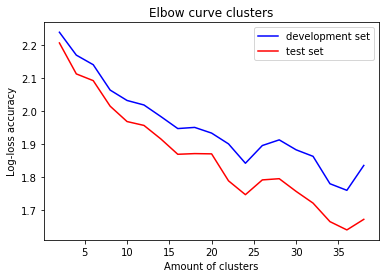

In [219]:
plot_cluster_graph(2, 40 , 2)

40
training took 30.083268642425537 seconds
['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken']
[0 0 0 0 0 0 0 0 0 0]
80
training took 38.87668561935425 seconds
['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken']
[0 0 0 0 0 0 0 0 0 0]
120
training took 35.89973735809326 seconds
['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken']
[0 0 0 0 0 0 0 0 0 0]
160
training took 39.17119574546814 seconds
['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken']
[0 0 0 0 0 0 0 0 0 0]
200
training took 58.83499336242676 seconds
['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken']
[0 0 0 0 0 0 0 0 0 0]
240
training took 55.36889386177063 seconds
['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chic

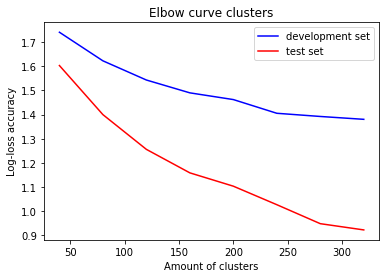

In [222]:
plot_cluster_graph(40, 360 , 40)

In [218]:
plot_cluster_graph(800, 3200 , 800)   

training took 56.72783160209656 seconds


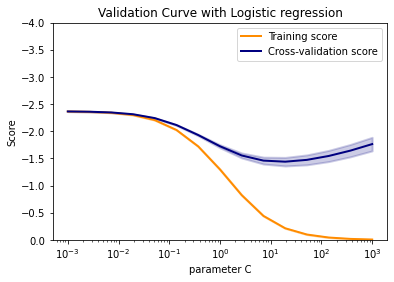

In [223]:
codebook_size = 175
clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=codebook_size)

param_range = np.logspace(-3, 3, 15)
train_scores, test_scores = validation_curve(
LogisticRegression(max_iter= 2000), X_DEV,Y_DEV, param_name="C", param_range=param_range,
    scoring=LogLoss, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Logistic regression")
plt.xlabel("parameter C")
plt.ylabel("Score")
plt.ylim(0.0, -4.0)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [228]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(max_iter= 2000 , C=10), 
                                                        train_data, 
                                                        train_labels,
                                                        # Number of folds in cross-validation
                                                        cv=ShuffleSplit(n_splits=3, test_size=0.4, random_state=43),
                                                        # Evaluation metric
                                                        scoring="accuracy",
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 20))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

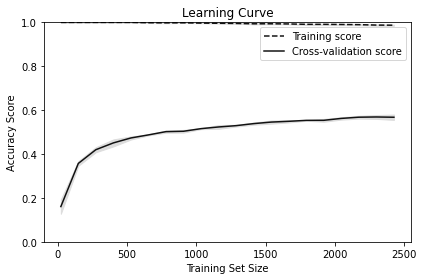

We now have feature vectors with hopefully meaningful BOVW representations, as well as a train label vector in the right format. We are all set to start and train a supervised model on our data, do feature selection, model evaluation etc. This is where you come in, of course. As a last step, we will show how to generate a sample submission for the competition homepage using a 'prior probability algorithm', which simply outputs the prior probabilities of the classes.

## 4. Making a submission
For our naive sample submission we just count the amount of training samples per class, and divide them by the total amount of samples to get our output probabilities for every test sample. <code>helpers.writePredictionsToCsv</code> can be used to write out predictions as a csv file ready to be submitted to the competition page.

In [147]:
# Compute a naive prediction
prior_predictions = np.array([len(train_paths[label]) for label in label_strings])
prior_predictions = prior_predictions / np.sum(prior_predictions)
print(prior_predictions)

prior_predictions = np.tile(prior_predictions, (len(test_paths), 1))
print(len(prior_predictions))

[0.13607125 0.10761999 0.06160317 0.11429985 0.01855517 0.11528946
 0.021524   0.0974765  0.07941613 0.10044532 0.05294409 0.09475507]
4035


## 5. Own classification

In [148]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, log_loss,make_scorer
from sklearn.svm import SVC
from sklearn import decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

## 6 Outlier detection

In [149]:
X = train_data
Y = train_labels

#### Scale the data

In [150]:
from sklearn.preprocessing import StandardScaler , RobustScaler
from sklearn.model_selection import learning_curve , validation_curve
from sklearn.model_selection import ShuffleSplit
#standardscaler didn't improve anything

scaler = RobustScaler()
scaler.fit(X)
X = scaler.transform(X)

In [151]:
X, X_DEV , Y , Y_DEV = train_test_split(train_data,train_labels,test_size = 0.8,random_state=42) #0.8 split gave us optimal results!
print(str(len(X)/len(X_DEV)))
LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

0.24984539270253556


### 5.2) Logistic regression classifier

#### 5.2.1) Cross-val score

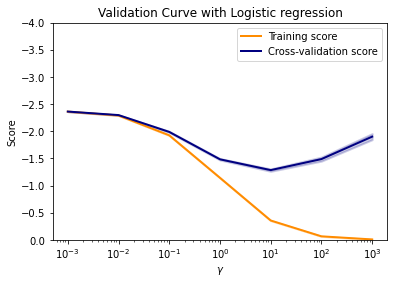

In [152]:
param_range = np.logspace(-3, 3, 7)
train_scores, test_scores = validation_curve(
LogisticRegression(max_iter= 2000), X_DEV,Y_DEV, param_name="C", param_range=param_range,
    scoring=LogLoss, n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Logistic regression")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, -4.0)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

#### 5.2.1) Cross-val score zoom in

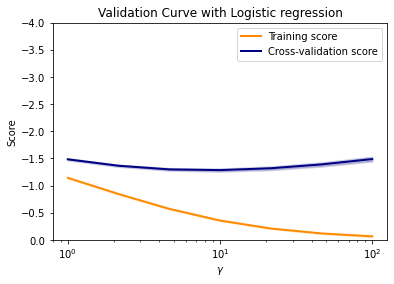

In [153]:
param_range = np.logspace(0, 2, 7)
train_scores, test_scores = validation_curve(
LogisticRegression(max_iter= 2000), X_DEV,Y_DEV, param_name="C", param_range=param_range,
    scoring=LogLoss, n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Logistic regression")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, -4.0)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

#### 5.2.2) Learning-curve 

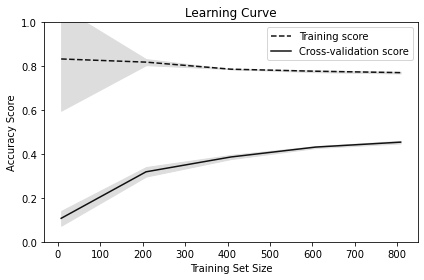

In [154]:
#https://chrisalbon.com/machine_learning/model_evaluation/plot_the_learning_curve/
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(max_iter= 2000), 
                                                        train_data, 
                                                        train_labels,
                                                        # Number of folds in cross-validation
                                                        cv=ShuffleSplit(n_splits=3, test_size=0.8, random_state=0),
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 5))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [155]:
#https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
#https://stackoverflow.com/questions/55892224/how-to-use-log-loss-scorer-in-gridsearchcv
grid={"C":np.logspace(-3,3,7), "penalty":["l2"]}

In [156]:
logreg = LogisticRegression(max_iter= 2000) #balanced gave worse results 
logreg_cv = GridSearchCV(logreg,grid,scoring=LogLoss,cv=10)
logreg_cv.fit(X_DEV,Y_DEV)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2'}
accuracy : -1.2678366701386135


In [157]:
#https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
#https://stackoverflow.com/questions/55892224/how-to-use-log-loss-scorer-in-gridsearchcv
grid={"C":np.logspace(-3,3,7), "penalty":["l2"] , "solver":["newton-cg"]}



LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
logreg = LogisticRegression(max_iter= 2000) #balanced gave worse results 
logreg_cv = GridSearchCV(logreg,grid,scoring=LogLoss,cv=10)
logreg_cv.fit(X_DEV,Y_DEV)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2', 'solver': 'newton-cg'}
accuracy : -1.2678483130346958


In [158]:
#https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
#https://stackoverflow.com/questions/55892224/how-to-use-log-loss-scorer-in-gridsearchcv
grid={"C":np.logspace(-3,3,7), "penalty":["l1"] , "solver":["liblinear"]}



LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
logreg = LogisticRegression(max_iter= 2000) #balanced gave worse results 
logreg_cv = GridSearchCV(logreg,grid,scoring=LogLoss,cv=10)
logreg_cv.fit(X_DEV,Y_DEV)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}
accuracy : -1.6508743463659212


In [168]:
#https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
#https://stackoverflow.com/questions/55892224/how-to-use-log-loss-scorer-in-gridsearchcv
grid={"C":np.logspace(-3,3,7), "penalty":["l2"] , "solver":["sag"]}



LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
logreg = LogisticRegression(max_iter= 2000) #balanced gave worse results 
logreg_cv = GridSearchCV(logreg,grid,scoring=LogLoss,cv=10)
logreg_cv.fit(X_DEV,Y_DEV)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2', 'solver': 'sag'}
accuracy : -1.3082384292580247


In [169]:
#https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
#https://stackoverflow.com/questions/55892224/how-to-use-log-loss-scorer-in-gridsearchcv
grid={"C":np.logspace(-3,3,7), "penalty":["l2"] , "solver":["saga"]}



LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
logreg = LogisticRegression(max_iter= 2000) #balanced gave worse results 
logreg_cv = GridSearchCV(logreg,grid,scoring=LogLoss,cv=10)
logreg_cv.fit(X_DEV,Y_DEV)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2', 'solver': 'saga'}
accuracy : -1.3082068208241564


In [159]:
from sklearn.metrics import plot_confusion_matrix

current log_loss: 1.3499274447921568
Confusion matrix, without normalization
[[244  16   2  11   0  31   1   2   1   1   0   1]
 [ 54 110   1  16   0  60   0  14   0   6   5   2]
 [  8   5  31  28   3   2   1  39   3  14   5   5]
 [ 14   6  18 158   2  13   0  34  14   8   4   7]
 [  2   3   3  12   5   1   0   6   0   4   3   1]
 [ 51  40   0   4   0 182   0   1   0   1   1   0]
 [  2   0   1   3   0   0  23   7   0   1   0  11]
 [  4   2  17  20   0   0   0 151  14   5   3  17]
 [  8   5  18  22   0   1   2  16  70  25   5  40]
 [ 13   7  12  27   2   4   0  19  18 130  11  15]
 [  4   2   4  13   0   1   0   1   6  14  74   2]
 [  8   2   9  14   0   1   1  20   6   9   5 158]]
Normalized confusion matrix
[[0.78709677 0.0516129  0.00645161 0.03548387 0.         0.1
  0.00322581 0.00645161 0.00322581 0.00322581 0.         0.00322581]
 [0.20149254 0.41044776 0.00373134 0.05970149 0.         0.2238806
  0.         0.05223881 0.         0.02238806 0.01865672 0.00746269]
 [0.05555556 0.0

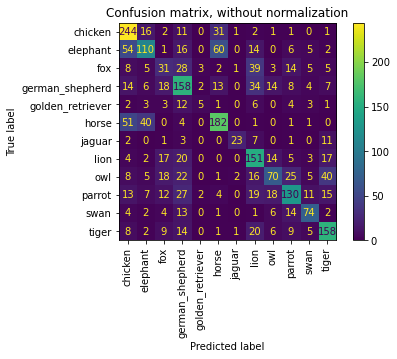

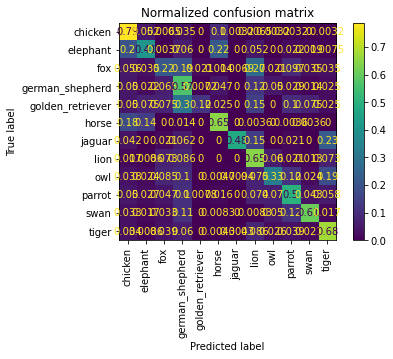

In [237]:
X, X_DEV , Y , Y_DEV = train_test_split(train_data,train_labels,test_size = 0.4,random_state=42) #0.8 split gave us optimal results!
logreg_best = LogisticRegression(C = 10 , penalty = 'l2' , max_iter= 2000 )
logreg_best.fit(X_DEV,Y_DEV)
logistic_regression_predictions = logreg_best.predict_proba(test_data)

y_pred = logreg_best.predict(X)
logistic_regression_train = logreg_best.predict_proba(X)
acc_logreg = log_loss(Y, logistic_regression_train)
print("current log_loss: " + str(acc_logreg))
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(logreg_best, X, Y,
                                 display_labels=label_strings,
                                 xticks_rotation='vertical',
                                 normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.show()

### 5.4) Decision tree classifier

In [161]:
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [162]:
#https://www.kaggle.com/shreayan98c/hyperparameter-tuning-tutorial
clf = tree.DecisionTreeClassifier()
# Hyperparameter Optimization
parameters = {'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10, 50], 
              'min_samples_split': [2, 3, 50, 100],
              'min_samples_leaf': [1, 5, 8, 10]
             }

# Run the grid search
grid_obj = GridSearchCV(clf, parameters,scoring=LogLoss)
grid_obj = grid_obj.fit(X_DEV, Y_DEV)
clf = grid_obj.best_estimator_

0.1485148514851485
current log loss: 2.3303163503341797
Confusion matrix, without normalization
[[253   0   0   0   0  63   0 234   0   0   0   0]
 [183   0   0   0   0  85   0 167   0   0   0   0]
 [ 61   0   0   0   0  11   0 177   0   0   0   0]
 [155   0   0   0   0  40   0 267   0   0   0   0]
 [ 23   0   0   0   0   9   0  43   0   0   0   0]
 [197   0   0   0   0 111   0 158   0   0   0   0]
 [  3   0   0   0   0   1   0  83   0   0   0   0]
 [ 41   0   0   0   0   1   0 352   0   0   0   0]
 [ 53   0   0   0   0   0   0 268   0   0   0   0]
 [111   0   0   0   0   9   0 286   0   0   0   0]
 [ 76   0   0   0   0   4   0 134   0   0   0   0]
 [ 50   0   0   0   0   1   0 332   0   0   0   0]]
Normalized confusion matrix
[[0.46       0.         0.         0.         0.         0.11454545
  0.         0.42545455 0.         0.         0.         0.        ]
 [0.42068966 0.         0.         0.         0.         0.1954023
  0.         0.38390805 0.         0.         0.         0.

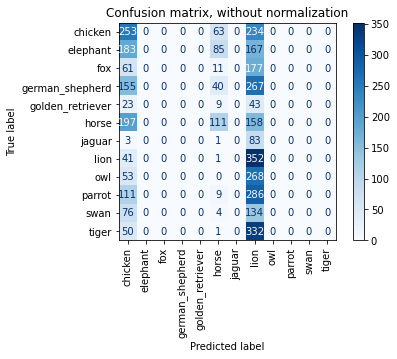

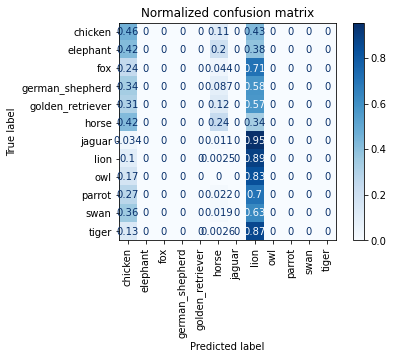

In [163]:
decisiontree_fit = clf.fit(X_DEV,Y_DEV)
decision_tree_predictions = clf.predict_proba(test_data)
print(clf.score(X,Y))
y_pred = clf.predict(X)
decision_tree_train = clf.predict_proba(X)
acc_dt = log_loss(Y, decision_tree_train)
print("current log loss: " + str(acc_dt))
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, train_data, train_labels,
                                 display_labels=label_strings,
                                 cmap=plt.cm.Blues,
                                 xticks_rotation='vertical',
                                 normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.show()

In [164]:
clf = tree.DecisionTreeClassifier()
# Hyperparameter Optimization random

param_dist = {"max_depth": randint(1,2000) ,
              "max_features": ['log2', 'sqrt','auto'],
              "min_samples_leaf": randint(1, 90),
              'min_samples_leaf': randint(1,100),
              "criterion": ["gini", "entropy"]}
# Run the grid search
grid_obj = RandomizedSearchCV(clf, param_dist,scoring=LogLoss)
grid_obj = grid_obj.fit(X_DEV, Y_DEV)
clf = grid_obj.best_estimator_
print(grid_obj.best_estimator_)
print(grid_obj.best_score_)

DecisionTreeClassifier(max_depth=1078, max_features='log2', min_samples_leaf=90)
-2.3544547664071716


In [165]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

### 5.x) decision forrest classifier

In [166]:
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# Hyperparameter Optimization
rf = RandomForestClassifier()
X, X_DEV , Y , Y_DEV = train_test_split(train_data,train_labels,test_size = 0.8,random_state=42) #0.8 split gave us optimal results!
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


# Run the grid search
grid_obj =  RandomizedSearchCV(estimator = rf,scoring=LogLoss, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
grid_obj = grid_obj.fit(X_DEV,Y_DEV)
print("tuned hpyerparameters :(best parameters) ",grid_obj.best_params_)
print("accuracy :",grid_obj.best_score_)
rf = grid_obj.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 46.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 86.9min finished


tuned hpyerparameters :(best parameters)  {'n_estimators': 1400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': False}
accuracy : -1.6935981516167669


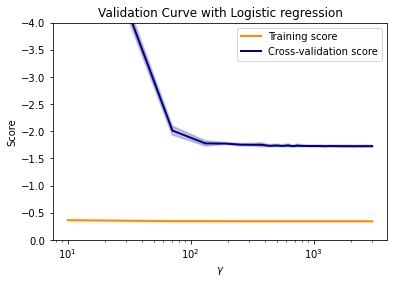

In [167]:
param_range = [int(x) for x in np.linspace(10, 3000, num = 50)]
train_scores, test_scores = validation_curve(
RandomForestClassifier(), X_DEV,Y_DEV, param_name="n_estimators", param_range=param_range,
    scoring=LogLoss, n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Logistic regression")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, -4.0)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

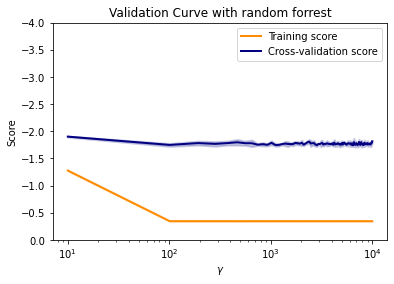

In [168]:
param_range = [int(x) for x in np.linspace(10, 10000, num = 110)]
train_scores, test_scores = validation_curve(
RandomForestClassifier(n_estimators = 200), X_DEV,Y_DEV, param_name="max_depth", param_range=param_range,
    scoring=LogLoss, n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with random forrest")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, -4.0)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

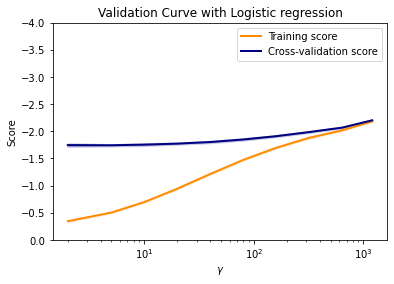

In [169]:
param_range = [2, 5, 10 , 20 , 40 , 80 , 160 , 320 , 640 , 1200]
train_scores, test_scores = validation_curve(
RandomForestClassifier(n_estimators = 300), X_DEV,Y_DEV, param_name="min_samples_split", param_range=param_range,
    scoring=LogLoss, n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Logistic regression")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, -4.0)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

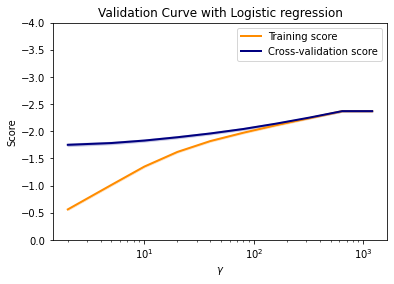

In [170]:
param_range = param_range = [2, 5, 10 , 20 , 40 , 80 , 160 , 320 , 640 , 1200]
train_scores, test_scores = validation_curve(
RandomForestClassifier(n_estimators = 300), X_DEV,Y_DEV, param_name="min_samples_leaf", param_range=param_range,
    scoring=LogLoss, n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Logistic regression")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, -4.0)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

current log loss: 17.998082576426388
Confusion matrix, without normalization
[[497  13   2   8   2  10   0   4   6   3   2   3]
 [ 22 365   3  14   0  15   1   3   0   8   1   3]
 [  5   4 199   7   0   4   2  11   6   8   2   1]
 [  9  10   5 395   2   8   0  10   7   8   4   4]
 [  0   4   1   1  62   0   0   1   0   5   1   0]
 [ 17  15   0   6   1 415   0   0   1   8   1   2]
 [  2   1   1   1   0   1  73   2   0   1   0   5]
 [  9   4   8   5   1   0   1 350   6   4   0   6]
 [  5   2   7   9   1   4   2   6 261  11   5   8]
 [  4   8   5   7   2   8   2   5   8 340   8   9]
 [  0   1   3   3   2   1   2   1   3   7 187   4]
 [  5   3   3  10   2   1   3  11  11   7   3 324]]
Normalized confusion matrix
[[0.90363636 0.02363636 0.00363636 0.01454545 0.00363636 0.01818182
  0.         0.00727273 0.01090909 0.00545455 0.00363636 0.00545455]
 [0.05057471 0.83908046 0.00689655 0.03218391 0.         0.03448276
  0.00229885 0.00689655 0.         0.0183908  0.00229885 0.00689655]
 [0.0200

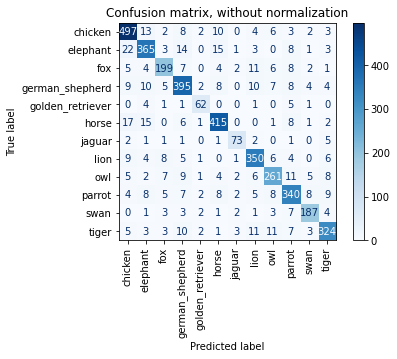

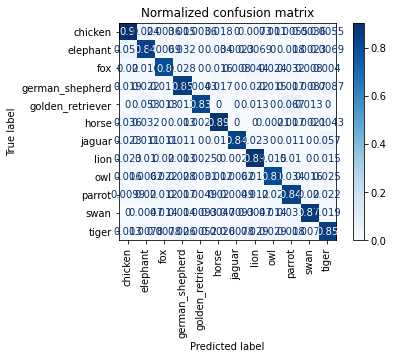

In [171]:
rf = RandomForestClassifier(n_estimators = 1600, min_samples_split = 2, min_samples_leaf = 1, max_features = None, max_depth =  100, bootstrap =  False, n_jobs = -1)
X, X_DEV , Y , Y_DEV = train_test_split(train_data,train_labels,test_size = 0.8,random_state=42) #0.8 split gave us optimal results!
rf.fit(X_DEV,Y_DEV)
Forest_prediction = rf.predict_proba(test_data)
y_pred=rf.predict(X)
decision_forrest_train = rf.predict_proba(X)
acc_rf = log_loss(Y, decision_forrest_train)
print("current log loss: " + str(acc_rf))
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rf, train_data, train_labels,
                                 display_labels=label_strings,
                                 cmap=plt.cm.Blues,
                                 xticks_rotation='vertical',
                                 normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.show()

In [172]:
CalibratedClassifierCV

NameError: name 'CalibratedClassifierCV' is not defined

### 5.1 Support Vector Machines

#### 5.1.1 Optimal parameters for SVM

In [173]:
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier

In [174]:
#https://www.kaggle.com/udaysa/svm-with-scikit-learn-svm-with-parameter-tuning
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}
                   ]
clf = GridSearchCV(SVC(C=1, probability=True), tuned_parameters, cv=5, scoring=LogLoss)
clf.fit(X_DEV,Y_DEV)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()
    

    

-1.820 (+/-0.081) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}

-1.821 (+/-0.091) for {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}

-1.814 (+/-0.073) for {'C': 0.001, 'gamma': 0.0001, 'kernel': 'rbf'}

-1.851 (+/-0.074) for {'C': 0.001, 'gamma': 1e-05, 'kernel': 'rbf'}

-1.695 (+/-0.056) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}

-1.753 (+/-0.089) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}

-1.812 (+/-0.093) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}

-1.821 (+/-0.071) for {'C': 0.1, 'gamma': 1e-05, 'kernel': 'rbf'}

-1.686 (+/-0.109) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}

-1.764 (+/-0.114) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}

-1.816 (+/-0.081) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}

-1.835 (+/-0.102) for {'C': 0.1, 'gamma': 1e-05, 'kernel': 'rbf'}

-1.467 (+/-0.071) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

-1.677 (+/-0.086) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

-1.705 (+/-0.049) for {'C': 10, 'gamma': 0.0001, 'kernel'

#### 5.1.1 Stacking classifier

In [175]:
from sklearn.ensemble import StackingClassifier
estimators = [
     ('rf',RandomForestClassifier(n_estimators = 1600, min_samples_split = 5, min_samples_leaf = 1, max_features =  'sqrt', max_depth =  70, bootstrap =  False)),
     ('logregg' , LogisticRegression(C = 4 , penalty = 'l2' , max_iter= 2000 , solver = 'saga')),
     ('svc' ,svm.SVC(C= 65 , kernel = 'rbf' ,gamma = 0.01, probability=True))]

clf1 = StackingClassifier(estimators=estimators, 
                         final_estimator=RandomForestClassifier(n_estimators = 1600, min_samples_split = 5, min_samples_leaf = 1, max_features =  'sqrt', max_depth =  70, bootstrap =  False) 
                         ,stack_method = 'predict_proba' )

clf1.fit(X_DEV,Y_DEV)
stack_1_pred = clf1.predict_proba(test_data)
print(clf1.score(X,Y))
y_pred = clf1.predict(X)
clf1_train = clf1.predict_proba(X)
acc_stack1 = log_loss(Y, clf1_train)
print("current log loss: " + str(acc_stack1))

0.6138613861386139
current log loss: 1.1867505597035846


In [176]:
clf2 = StackingClassifier(estimators=estimators, 
                         final_estimator = LogisticRegression(C = 4 , penalty = 'l2' , max_iter= 2000 , solver = 'saga')
                         ,stack_method = 'predict_proba' )

clf2.fit(X_DEV,Y_DEV)
stack_2_pred = clf2.predict_proba(test_data)
print(clf2.score(X,Y))
y_pred = clf2.predict(X)

0.6076732673267327


In [177]:
clf2_train = clf2.predict_proba(X)
acc_stack2 = log_loss(Y, clf2_train)
print("current log loss: " + str(acc_stack2))

current log loss: 1.1907644240788617


Confusion matrix, without normalization
[[75  6  0  0  0  6  0  0  2  1  0  1]
 [15 43  0  5  0 20  0  4  0  2  0  1]
 [ 2  2 20 12  0  0  0 16  1  6  0  1]
 [ 5  0  6 61  0  2  0  5  3  5  2  1]
 [ 1  0  0  7  2  0  0  2  0  1  1  0]
 [ 6 15  0  2  0 56  0  0  0  1  0  0]
 [ 1  0  0  0  0  0 12  1  0  0  0  1]
 [ 0  3  7  5  0  0  1 46  2  4  1  2]
 [ 0  0  1  5  0  0  1  7 37 12  1  8]
 [ 0  4  3  4  2  1  0  5 10 54  5  3]
 [ 0  1  0  3  0  0  0  0  4 10 23  1]
 [ 1  1  2  6  0  0  0  8  5  6  1 62]]
Normalized confusion matrix
[[0.82417582 0.06593407 0.         0.         0.         0.06593407
  0.         0.         0.02197802 0.01098901 0.         0.01098901]
 [0.16666667 0.47777778 0.         0.05555556 0.         0.22222222
  0.         0.04444444 0.         0.02222222 0.         0.01111111]
 [0.03333333 0.03333333 0.33333333 0.2        0.         0.
  0.         0.26666667 0.01666667 0.1        0.         0.01666667]
 [0.05555556 0.         0.06666667 0.67777778 0.         0.0

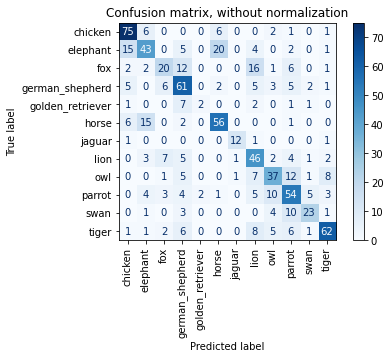

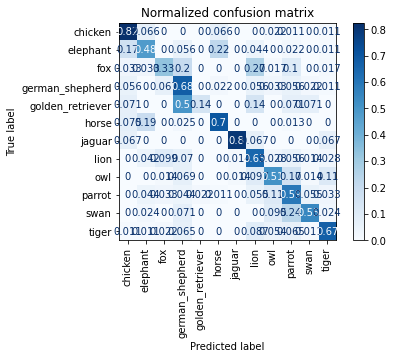

In [178]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf2, X, Y,
                                 display_labels=label_strings,
                                 cmap=plt.cm.Blues,
                                 xticks_rotation='vertical',
                                 normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.show()

In [179]:
clf3 = StackingClassifier(estimators=estimators, 
                         final_estimator = svm.SVC(C= 65 , kernel = 'rbf' ,gamma = 0.01, probability=True)
                         ,stack_method = 'predict_proba' )

clf3.fit(X_DEV,Y_DEV)
stack_3_pred = clf3.predict_proba(test_data)
print(clf3.score(X,Y))
y_pred = clf3.predict(X)
clf3_train = clf3.predict_proba(X)
acc_stack3 = log_loss(Y, clf3_train)
print("current log loss: " + str(acc_stack3))

0.6027227722772277
current log loss: 1.2027686700268319


In [180]:
estimators = [
     ('logregg' , LogisticRegression(C = 4 , penalty = 'l2' , max_iter= 2000 , solver = 'saga')),
     ('svc' ,svm.SVC(C= 60 , kernel = 'rbf' ,gamma = 0.01, probability=True))]

clf4 = StackingClassifier(estimators=estimators,
                          final_estimator = svm.SVC(C= 60 , kernel = 'rbf' ,gamma = 0.01, probability=True)
                         ,stack_method = 'predict_proba' )

clf4.fit(X_DEV,Y_DEV)
stack_4_pred = clf4.predict_proba(test_data)
print(clf4.score(X,Y))
y_pred = clf4.predict(X)
clf4_train = clf4.predict_proba(X)
acc_stack4 = log_loss(Y, clf4_train)
print("current log loss: " + str(acc_stack4))

0.599009900990099
current log loss: 1.2198544645664904


In [181]:
clf5 = StackingClassifier(estimators=estimators, 
                         final_estimator = LogisticRegression(C = 4 , penalty = 'l2' , max_iter= 2000 , solver = 'saga')
                         ,stack_method = 'predict_proba' )

clf5.fit(X_DEV,Y_DEV)

StackingClassifier(estimators=[('logregg',
                                LogisticRegression(C=4, max_iter=2000,
                                                   solver='saga')),
                               ('svc',
                                SVC(C=60, gamma=0.01, probability=True))],
                   final_estimator=LogisticRegression(C=4, max_iter=2000,
                                                      solver='saga'),
                   stack_method='predict_proba')

In [182]:
stack_5_pred = clf5.predict_proba(test_data)
print(clf5.score(X,Y))
y_pred = clf5.predict(X)
clf5_train = clf5.predict_proba(X)
acc_stack5 = log_loss(Y, clf5_train)
print("current log loss: " + str(acc_stack5))
                                 
  

0.5915841584158416
current log loss: 1.2166564600286438


In [183]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(pipeline, X, Y,
                                 display_labels=label_strings,
                                 cmap=plt.cm.Blues,
                                 xticks_rotation='vertical',
                                 normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.show()

NameError: name 'pipeline' is not defined

#### Finetune of above finetune

In [184]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-2],
                     'C': [45,50 ,55, 60,65]}]
clf = GridSearchCV(SVC(C=1, probability=True), tuned_parameters, cv=5, scoring=LogLoss)
clf.fit(X_DEV,Y_DEV)

GridSearchCV(cv=5, estimator=SVC(C=1, probability=True),
             param_grid=[{'C': [45, 50, 55, 60, 65], 'gamma': [0.01],
                          'kernel': ['rbf']}],
             scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True))

In [185]:
print(clf.best_params_)

{'C': 65, 'gamma': 0.01, 'kernel': 'rbf'}


#### 5.1.1) Cross-val score

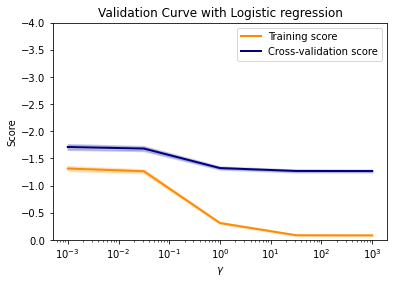

In [186]:
param_range = np.logspace(-3, 3, 5)
train_scores, test_scores = validation_curve(
SVC(C=1, probability=True), X_DEV,Y_DEV, param_name="C", param_range=param_range,
    scoring=LogLoss, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Logistic regression")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, -4.0)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

#### 5.2.2) Learning-curve 

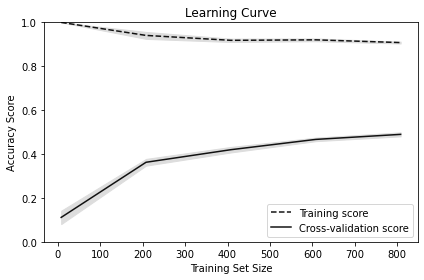

In [188]:
#https://chrisalbon.com/machine_learning/model_evaluation/plot_the_learning_curve/
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(SVC(C= 60 , kernel = 'rbf' ,gamma = 0.01, probability=True), 
                                                        train_data, 
                                                        train_labels,
                                                        # Number of folds in cross-validation
                                                        cv=ShuffleSplit(n_splits=3, test_size=0.8, random_state=0),
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 5))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [234]:
svm_clf = svm.SVC(C= 10 , kernel = 'rbf' ,gamma = 0.01, probability=True , shrinking = False) #class weight balanced gives worse results!!!
svm_clf.fit(X_DEV,Y_DEV)
support_vector_machines_predictions = svm_clf.predict_proba(test_data)
print(svm_clf.score(X,Y))
y_pred = svm_clf.predict(X)
svm_train = svm_clf.predict_proba(X)
acc_svm = log_loss(Y, svm_train)
print("current log loss: " + str(acc_svm))

0.46782178217821785
current log loss: 1.4067844094732747


In [190]:
svm_clf = svm.SVC(C= 1000 , kernel = 'rbf' ,gamma = 0.001, probability=True , shrinking = False) #class weight balanced gives worse results!!!
svm_clf.fit(X_DEV,Y_DEV)
support_vector_machines_predictions = svm_clf.predict_proba(test_data)
print(svm_clf.score(X,Y))
y_pred = svm_clf.predict(X)
svm_train = svm_clf.predict_proba(X)
acc_svm = log_loss(Y, svm_train)
print("current log loss: " + str(acc_svm))

0.5767326732673267
current log loss: 1.2156139668398795


In [191]:
#https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html#sphx-glr-auto-examples-compose-plot-compare-reduction-py
from sklearn.pipeline import Pipeline
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV


calibrated = CalibratedClassifierCV(svm.SVC(C= 50 , kernel = 'rbf' ,gamma = 0.01, probability=True , shrinking = False), method='sigmoid', cv=5)
calibrated.fit(X_DEV,Y_DEV)
support_vector_machines_predictions = calibrated.predict_proba(test_data)
print(calibrated.score(X,Y))
y_pred = calibrated.predict(X)
callibrated_train = calibrated.predict_proba(X)
acc_calibrated = log_loss(Y, callibrated_train)
print("current log loss: " + str(acc_calibrated))

0.5556930693069307
current log loss: 1.3955428025009255


In [192]:
calibrated = CalibratedClassifierCV(svm.SVC(C= 50 , kernel = 'rbf' ,gamma = 0.01, probability=True , shrinking = False), method='isotonic', cv=5)
calibrated.fit(X_DEV,Y_DEV)
support_vector_machines_predictions = calibrated.predict_proba(test_data)
print(calibrated.score(X,Y))
y_pred = calibrated.predict(X)
callibrated_train = calibrated.predict_proba(X)
acc_calibrated = log_loss(Y, callibrated_train)
print("current log loss: " + str(acc_calibrated))

0.5693069306930693
current log loss: 1.2955927829103422


In [193]:
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(svm.SVC(C= 50 , kernel = 'rbf' ,gamma = 0.01, probability=True , shrinking = False) , n_jobs = -1)
clf.fit(X_DEV,Y_DEV)
one_vs_rest_predictions = clf.predict_proba(test_data)
print(clf.score(X,Y))
y_pred = clf.predict(X)
one_vs_train = clf.predict_proba(X)
acc_onevsrest = log_loss(Y, one_vs_train)
print("current log loss: " + str(acc_onevsrest))

0.5594059405940595
current log loss: 1.3240818655408115


Confusion matrix, without normalization
[[522   4   0   3   0  16   0   1   1   0   2   1]
 [ 29 344   1   9   0  41   0   6   0   3   1   1]
 [  6   5 172  23   1   2   0  25   5   7   2   1]
 [ 12   1   9 395   0  11   0  15   3   5   8   3]
 [  2   6   2  10  43   1   0   7   1   1   2   0]
 [ 17  26   0   3   0 420   0   0   0   0   0   0]
 [  1   0   0   1   0   0  79   2   0   0   0   4]
 [  0   1  13  12   0   0   1 355   4   4   1   3]
 [  2   2   9   8   0   0   1   9 265  12   2  11]
 [  0   5   9  11   2   2   0   8  14 346   6   3]
 [  0   2   1   4   0   0   0   0   5  10 191   1]
 [  2   0   2  14   0   1   0  20  11   4   1 328]]
Normalized confusion matrix
[[0.94909091 0.00727273 0.         0.00545455 0.         0.02909091
  0.         0.00181818 0.00181818 0.         0.00363636 0.00181818]
 [0.06666667 0.7908046  0.00229885 0.02068966 0.         0.09425287
  0.         0.0137931  0.         0.00689655 0.00229885 0.00229885]
 [0.02409639 0.02008032 0.69076305 0.09236948

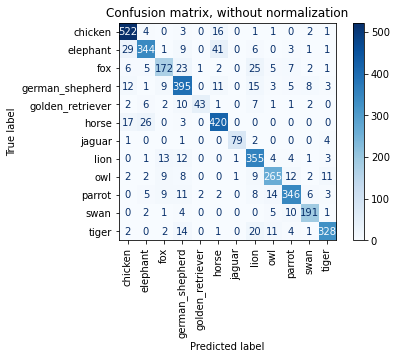

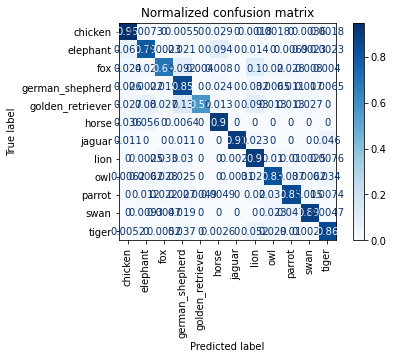

In [194]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(svm_clf, train_data, train_labels,
                                 display_labels=label_strings,
                                 cmap=plt.cm.Blues,
                                 xticks_rotation='vertical',
                                 normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.show()
    

### 5.3) Gaussian classifier 

0.34777227722772275


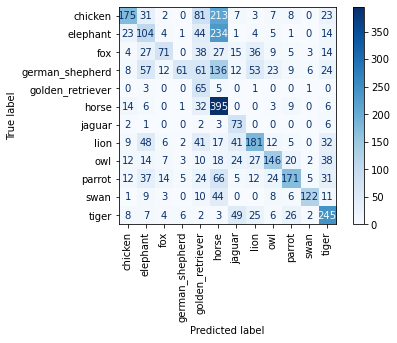

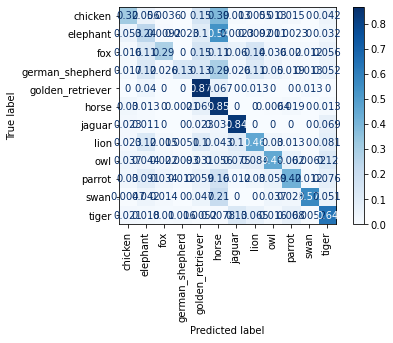

In [195]:
clf = GaussianNB()
Gaussian_predictions2 = clf.fit(X_DEV,Y_DEV)
Gaussian_predictions = clf.predict_proba(test_data)
print(clf.score(X,Y))
y_pred = clf.predict(X)
nb_train = clf.predict_proba(X)
acc_nb = log_loss(Y,nb_train)
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, train_data, train_labels,
                                 display_labels=label_strings,
                                 cmap=plt.cm.Blues,
                                 xticks_rotation='vertical',
                               normalize=normalize)


### 5.4) K-Nearest Neighbors classifier

In [196]:
# Import library of KNeighborsClassifier model
from sklearn.neighbors import KNeighborsClassifier

# Create a KNN Classifier
knn = KNeighborsClassifier()

# Hyperparameter Optimization
parameters = {'n_neighbors': [3, 4, 5, 10], 
              'weights': ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size' : [10, 20, 30, 50]
             }

# Run the grid search
grid_obj = GridSearchCV(knn, parameters,scoring=LogLoss)
grid_obj = grid_obj.fit(X_DEV, Y_DEV)

print("tuned hpyerparameters :(best parameters) ",grid_obj.best_params_)
print("accuracy :",grid_obj.best_score_)
# Set the knn to the best combination of parameters
knn = grid_obj.best_estimator_

KeyboardInterrupt: 

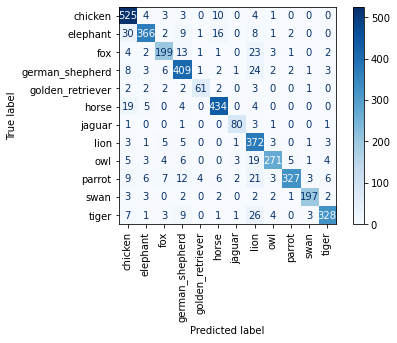

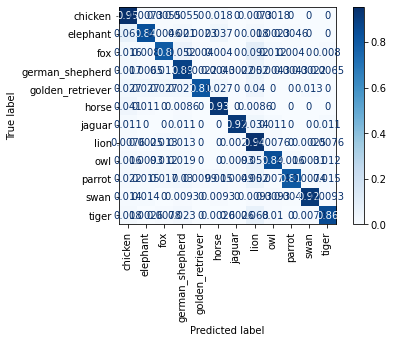

In [197]:
from sklearn.neighbors import KNeighborsClassifier
# Train the model using the training sets
knn = KNeighborsClassifier(algorithm = 'auto', leaf_size = 10, n_neighbors = 10, weights = 'distance')
knn.fit(X_DEV,Y_DEV)
KNNclassifier_predictions = knn.predict_proba(test_data)
y_pred = knn.predict(X)
knn_train = knn.predict_proba(X)
acc_knn = log_loss(Y, knn_train)
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(knn, train_data, train_labels,
                                 display_labels=label_strings,
                                 cmap=plt.cm.Blues,
                                 xticks_rotation='vertical',
                                 normalize=normalize)
    
 

## SGD Classifier

In [198]:
#https://www.knowledgehut.com/tutorials/machine-learning/hyperparameter-tuning-machine-learning
loss = [ 'log', 'modified_huber']
penalty = ['l1', 'l2', 'elasticnet'] 
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] 
learning_rate = ['constant', 'optimal', 'invscaling', 'adaptive'] 
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}] 
eta0 = [1, 10, 100] 
param_distributions = dict(loss=loss, 
penalty=penalty, 
alpha=alpha, 
learning_rate=learning_rate, 
class_weight=class_weight, 
eta0=eta0)

from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier 
from sklearn.model_selection import RandomizedSearchCV 
sgd = SGDClassifier(loss="hinge", penalty="l2", max_iter=5) 
random = RandomizedSearchCV(estimator=sgd, 
param_distributions=param_distributions, 
scoring=LogLoss, 
verbose=1, n_jobs=-1, 
n_iter=1000)
random.fit(X_DEV,Y_DEV)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 30.2min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 44.1min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 60.3min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 79.0min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 100.1min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 123.8min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed: 124.0min finished
C:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.


RandomizedSearchCV(estimator=SGDClassifier(max_iter=5), n_iter=1000, n_jobs=-1,
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100, 1000],
                                        'class_weight': [{0: 0.5, 1: 0.5},
                                                         {0: 0.6, 1: 0.4},
                                                         {0: 0.4, 1: 0.6},
                                                         {0: 0.3, 1: 0.7}],
                                        'eta0': [1, 10, 100],
                                        'learning_rate': ['constant', 'optimal',
                                                          'invscaling',
                                                          'adaptive'],
                                        'loss': ['log', 'modified_huber'],
                                        'penalty': ['l1', 'l2', 'elasticnet']},
                   scoring=make_s

In [199]:
calibrator = CalibratedClassifierCV(random, cv='prefit')
model=calibrator.fit(X_DEV, Y_DEV)
SGDclassifier_predictions = model.predict_proba(test_data)
sgd_train = model.predict_proba(X)
acc_sgn = log_loss(Y, sgd_train)
print("This is the current logLoss:  " + str(acc_sgn))

This is the current logLoss:  1.3694550324603527


### 

In [200]:
import pandas as pd
models = pd.DataFrame({
    'Model': ['Logistic Regression', 
              'Support Vector Machines', 
              'SGD Classifier' ,  
              'K-Nearest Neighbors classifier' , 
              'Gaussian classifier' , 
              'Decision-forrest classifier',],
    'Score': [acc_logreg, acc_svm, acc_sgn  , acc_knn , acc_nb , acc_rf ]})
models.sort_values(by='Score', ascending=True)

,Model,Score
1,Support Vector Machines,1.215614
0,Logistic Regression,1.232235
2,SGD Classifier,1.369455
3,K-Nearest Neighbors classifier,6.674294
5,Decision-forrest classifier,17.998083
4,Gaussian classifier,22.117389


In [203]:
# Build a submission
pred_file_path = os.path.join(prediction_path, helpers.generateUniqueFilename('logistic_regression_predictions_proba' , 'csv'))
helpers.writePredictionsToCsv(logistic_regression_predictions, pred_file_path, label_strings)

#Submitting the csv file generated should give you a public leaderboard score of about 2.36. It's up to you now to build a classifier that at least beats these prior scores (and then keep improving of course). Good luck competing!